# Aim of this Notebook

Given a dataset concerning several option contracts on SPY, we aim to assess the Implied Volatility according to the Black and Scholes Framework. After preprocessing the raw dataset, the conceptual steps are as follows:

- Construct the model using the function bs_price, which calculates the Black-Scholes price.

- Develop a function to calibrate the only parameter of a GBM risk-neutral dynamics, i.e., the diffusion coefficient.

If the model prices closely resemble the market prices, the calibration outcome yields the implied volatility, i.e., the value of the diffusion coefficient that equalizes model prices and market prices.

> Warning: "The implied volatility is a wrong number that you put in a wrong equation to obtain the correct price" (Riccardo Rebonato).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
import pandas as pd
import datetime as dt
import scipy

np.random.seed(100)

# IMPORT AND DATASET PREPARATION

In [3]:
df = pd.read_csv('spy.options.20150103.0105.csv')

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df[' expiration'] = pd.to_datetime(df[' expiration'], format='%Y-%m-%d')
df= df[df[' expiration']>dt.datetime(2015,1,5)]
df = df[df[' put/call']=='C']
df['price']= (df[' ask']+df[' bid'])/2
df = df[df['price']>0]

In [5]:
df

,date,symbol,under,expiration,strike,put/call,bid,ask,price,volume,open interest,implied vol,delta,gamma,rho,theta,vega,nonstd,price
180,2015-01-05,SPY 150109C00120000,SPY,2015-01-09,120.0,C,81.73,82.0,87.16,0,10,2.192690,0.991285,0.000510,0.012942,-0.136783,0.004990,104,81.865
181,2015-01-05,SPY 150109C00125000,SPY,2015-01-09,125.0,C,76.73,77.0,82.16,0,10,2.036740,0.990642,0.000585,0.013476,-0.135228,0.005311,104,76.865
182,2015-01-05,SPY 150109C00130000,SPY,2015-01-09,130.0,C,71.73,72.0,77.17,0,10,1.886320,0.989927,0.000673,0.014008,-0.133559,0.005664,104,71.865
183,2015-01-05,SPY 150109C00135000,SPY,2015-01-09,135.0,C,66.73,67.0,72.17,0,10,1.740920,0.989126,0.000780,0.014538,-0.131762,0.006054,104,66.865
184,2015-01-05,SPY 150109C00140000,SPY,2015-01-09,140.0,C,61.73,62.0,67.17,0,10,1.600070,0.988221,0.000910,0.015066,-0.129822,0.006490,104,61.865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4882,2015-01-05,SPY7 170120C00200000,SPY,2017-01-20,200.0,C,17.95,42.9,19.01,0,51,0.113826,0.000000,0.000000,0.000000,0.000000,0.000000,7,30.425
4883,2015-01-05,SPY7 170120C00205000,SPY,2017-01-20,205.0,C,0.00,25.0,18.00,0,7,0.113826,0.000000,0.000000,0.000000,0.000000,0.000000,7,12.500
4884,2015-01-05,SPY7 170120C00210000,SPY,2017-01-20,210.0,C,0.00,25.0,16.14,0,5,0.113826,0.000000,0.000000,0.000000,0.000000,0.000000,7,12.500
4885,2015-01-05,SPY7 170120C00215000,SPY,2017-01-20,215.0,C,0.00,25.0,10.13,0,1,0.113826,0.000000,0.000000,0.000000,0.000000,0.000000,7,12.500


In [6]:
df.reset_index(inplace = True)

In [7]:
stock_price = [201.76]*len(df) # underlying asset price 2015-1-5

ttm = []
for i in range(len(df)):
    ttm.append((df.loc[i,' expiration']-df.loc[i,'date']).total_seconds()/(365*86400))

df['stock_price']=stock_price
df['ttm']=ttm

# IMPLIED VOLATILITY

In [8]:
def bs_price(T, sigma, S, K, r):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/sigma*np.sqrt(T)
    d2 = d1-sigma*np.sqrt(T)
        
    return S*scipy.stats.norm.cdf(d1,0,1)-K*np.exp(-r*T)*scipy.stats.norm.cdf(d2,0,1)

def calibrate_gbm(T, S, K, r,data):
    def bs_price_wrapper(T, sigma):
        return bs_price(T, sigma, S, K, r)
    popt, pcov = curve_fit(bs_price_wrapper, T, data, bounds=(0,2))

    return popt

In [9]:
imp_vol = {}
for i in range(len(df)):
    strike = df.loc[i,' strike']
    ttm = df.loc[i,'ttm']
    if str(strike) in imp_vol.keys():
        imp_vol[str(strike)][str(ttm)]=calibrate_gbm(ttm, df['stock_price'][0], strike, 0.03, df.loc[i,'price'])
    else:
        imp_vol[str(strike)]={}
        imp_vol[str(strike)][str(ttm)]=calibrate_gbm(ttm, df['stock_price'][0], strike, 0.03, df.loc[i,'price'])
    

In [10]:
S = df.loc[0,'stock_price']
r = 0.03
prices = []

for i in range(len(df)):
    ttm = df.loc[i,'ttm']
    k = df.loc[i,' strike']
    sigma = imp_vol[str(k)][str(ttm)]
    
    
    prices.append(bs_price(ttm,sigma,S,k,r))

### METHOD DIAGNOSTIC

Text(0.5, 1.0, 'Calibration Outcome, Actual vs. Fitted')

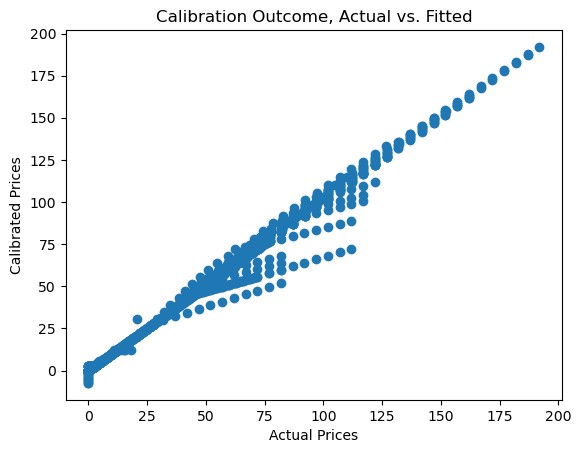

In [11]:
plt.scatter(df['price'],prices)
plt.xlabel('Actual Prices')
plt.ylabel('Calibrated Prices')
plt.title('Calibration Outcome, Actual vs. Fitted')

### IMPLIED VOLATILITY PLOTTING

Text(0.5, 1.0, 'Implied Volatility according to Black and Scholes Model')

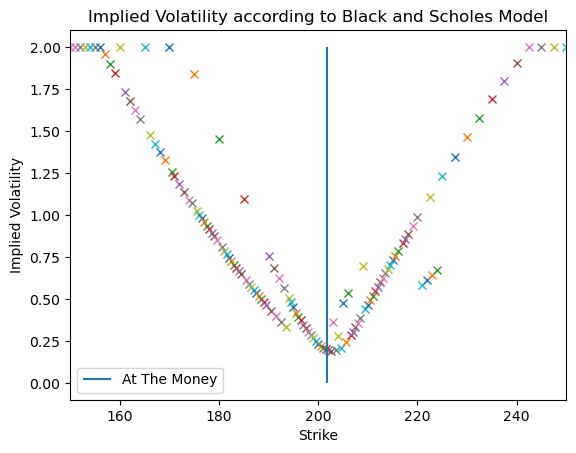

In [12]:
for k in list(imp_vol.keys()):
    ttm = list(imp_vol[k].keys())[0]
    plt.plot(float(k),imp_vol[k][ttm],'x')
plt.vlines(201.76,0,2,label='At The Money')
plt.xlim([150,250])
plt.legend()
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility according to Black and Scholes Model')